In [1]:
!nvidia-smi

Tue Feb 21 04:29:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from skimage.transform import resize
from imageio import imread

In [3]:
# Importing the necessary libraries

import numpy as np
import os

import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

tf.random.set_seed(30)

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
project_folder = !unzip '/content/drive/MyDrive/Colab_Notebooks/Project_data.zip'

In [9]:
project_folder = '/content/Project_data'

In [10]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [11]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=16,batch_size=8,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [ ]:
# class ModelConv3D1(ModelBuilder):
    
#     def define_model(self):

#         model = Sequential()
#         model.add(Conv3D(16, (3, 3, 3), padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(32, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(64, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(128, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Flatten())
#         model.add(Dense(128,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.5))

#         model.add(Dense(64,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.25))


#         model.add(Dense(self.num_classes,activation='softmax'))

#         optimiser = optimizers.Adam()
#         #optimiser = 'sgd'
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# conv_3d1=ModelConv3D1()
# conv_3d1.initialize_path(project_folder)
# conv_3d1.initialize_image_properties(image_height=160,image_width=160)
# conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=1)
# conv_3d1_model=conv_3d1.define_model()
# conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 80, 80, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 80, 80, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 80, 80, 32)     0

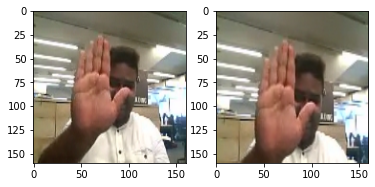

In [ ]:
# test_generator=ModelConv3D1()
# test_generator.initialize_path(project_folder)
# test_generator.initialize_image_properties(image_height=160,image_width=160)
# test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=3,num_epochs=1)

# g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
# batch_data, batch_labels=next(g)
# fig, axes = plt.subplots(nrows=1, ncols=2)
# axes[0].imshow(batch_data[0,15,:,:,:])   
# axes[1].imshow(batch_data[3,15,:,:,:])   
# plt.show()

In [ ]:
# conv_3d1.train_model(conv_3d1_model)

83/83 [==============================] - ETA: 0s - loss: 1.7577 - categorical_accuracy: 0.3680
Epoch 1: val_loss improved from inf to 3.22055, saving model to model_init_2023-02-1811_25_55.495895/model-00001-1.75767-0.36802-3.22055-0.16000.h5
83/83 [==============================] - 98s 1s/step - loss: 1.7577 - categorical_accuracy: 0.3680 - val_loss: 3.2206 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [ ]:
# conv_3d1=ModelConv3D1()
# conv_3d1.initialize_path(project_folder)
# conv_3d1.initialize_image_properties(image_height=100,image_width=100)
# conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=4,num_epochs=3)
# conv_3d1_model=conv_3d1.define_model()
# print("Total Params:", conv_3d1_model.count_params())
# conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
166/166 [==============================] - ETA: 0s - loss: 1.8362 - categorical_accuracy: 0.3288
Epoch 1: val_loss improved from inf to 3.38683, saving model to model_init_2023-02-1811_27_35.034326/model-00001-1.83619-0.32881-3.38683-0.20000.h5
166/166 [==============================] - 77s 459ms/step - loss: 1.8362 - categorical_accuracy: 0.3288 - val_loss: 3.3868 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/3
166/166 [==============================] - ETA: 0s - loss: 1.6602 - categorical_accuracy: 0.3469
Epoch 2: val_loss improved from 3.38683 to 2.51439, saving model to model_init_2023-02-1811_27_35.034326/model-00002-1.66021-0.34691-2.51439-0.21000.h5
166/166 [==============================] - 76s 458ms/step - loss: 1.6602 - categorical_accuracy: 0.3469 - val_loss: 2.5144 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/3
166/166 [==============================] - ETA: 0s - loss: 1.6195 - categorical_accuracy: 0.3484
Epoch 3: val_los

In [ ]:
# conv_3d1=ModelConv3D1()
# conv_3d1.initialize_path(project_folder)
# conv_3d1.initialize_image_properties(image_height=100,image_width=100)
# conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=3)
# conv_3d1_model=conv_3d1.define_model()
# print("Total Params:", conv_3d1_model.count_params())
# conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
83/83 [==============================] - ETA: 0s - loss: 1.7414 - categorical_accuracy: 0.3725
Epoch 1: val_loss improved from inf to 6.25352, saving model to model_init_2023-02-1811_31_23.202478/model-00001-1.74145-0.37255-6.25352-0.16000.h5
83/83 [==============================] - 79s 943ms/step - loss: 1.7414 - categorical_accuracy: 0.3725 - val_loss: 6.2535 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/3
83/83 [==============================] - ETA: 0s - loss: 1.4311 - categorical_accuracy: 0.4374
Epoch 2: val_loss did not improve from 6.25352
83/83 [==============================] - 76s 923ms/step - loss: 1.4311 - categorical_accuracy: 0.4374 - val_loss: 8.2517 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/3
83/83 [==============================] - ETA: 0s - loss: 1.2001 - categorical_accuracy: 0.5038
Epoch 3: val_loss improved from 6.25352 to 5.84817, saving model to model_init_2023-02-1811_31_23.202478/model-00003-1.20006-0.5037

In [ ]:
# conv_3d1=ModelConv3D1()
# conv_3d1.initialize_path(project_folder)
# conv_3d1.initialize_image_properties(image_height=100,image_width=100)
# conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=3)
# conv_3d1_model=conv_3d1.define_model()
# print("Total Params:", conv_3d1_model.count_params())
# conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
42/42 [==============================] - ETA: 0s - loss: 1.5902 - categorical_accuracy: 0.4299
Epoch 1: val_loss improved from inf to 3.13635, saving model to model_init_2023-02-1811_35_14.105507/model-00001-1.59023-0.42986-3.13635-0.21000.h5
42/42 [==============================] - 89s 2s/step - loss: 1.5902 - categorical_accuracy: 0.4299 - val_loss: 3.1364 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/3
42/42 [==============================] - ETA: 0s - loss: 1.1566 - categorical_accuracy: 0.5626
Epoch 2: val_loss did not improve from 3.13635
42/42 [==============================] - 88s 2s/step - loss: 1.1566 - categorical_accuracy: 0.5626 - val_loss: 5.7630 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/3
42/42 [==============================] - ETA: 0s - loss: 0.9577 - categorical_accuracy: 0.6335
Epoch 3: val_loss did not improve from 3.13635
42/42 [==============================] - 88s 2s/step - loss: 0.9577 - categorical_accurac

In [ ]:
# conv_3d1=ModelConv3D1()
# conv_3d1.initialize_path(project_folder)
# conv_3d1.initialize_image_properties(image_height=160,image_width=160)
# conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=3)
# conv_3d1_model=conv_3d1.define_model()
# print("Total Params:", conv_3d1_model.count_params())
# conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389


Epoch 1/3
21/21 [==============================] - ETA: 0s - loss: 1.7128 - categorical_accuracy: 0.4072
Epoch 1: val_loss improved from inf to 2.10303, saving model to model_init_2023-02-1811_39_41.209235/model-00001-1.71282-0.40724-2.10303-0.19000.h5
21/21 [==============================] - 90s 4s/step - loss: 1.7128 - categorical_accuracy: 0.4072 - val_loss: 2.1030 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/3
21/21 [==============================] - ETA: 0s - loss: 1.0887 - categorical_accuracy: 0.5762
Epoch 2: val_loss did not improve from 2.10303
21/21 [==============================] - 88s 4s/step - loss: 1.0887 - categorical_accuracy: 0.5762 - val_loss: 4.0411 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/3
21/21 [==============================] - ETA: 0s - loss: 0.7996 - categorical_accuracy: 0.7164
Epoch 3: val_loss did not improve from 2.10303
21/21 [==============================] - 87s 4s/step - loss: 0.7996 - categorical_accuracy: 0.7164 - val_loss: 

Model 2

Base Model - Batch Size = 8 and No. of Epochs = 30

In [ ]:
# class ModelConv3D1(ModelBuilder):
    
#     def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

#         model = Sequential()
#         model.add(Conv3D(16, filtersize, padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(32, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(64, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(128, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Flatten())
#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))

#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))


#         model.add(Dense(self.num_classes,activation='softmax'))

#         optimiser = optimizers.Adam()
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# conv_3d1=ModelConv3D1()
# conv_3d1.initialize_path(project_folder)
# conv_3d1.initialize_image_properties(image_height=160,image_width=160)
# conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
# conv_3d1_model=conv_3d1.define_model()
# conv_3d1_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 160, 160, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 16, 160, 160, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 16, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 8, 80, 80, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 80, 80, 32)     13856     
                                                                 
 activation_21 (Activation)  (None, 8, 80, 80, 32)    

In [ ]:
# print("Total Params:", conv_3d1_model.count_params())
# history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.6754 - categorical_accuracy: 0.3891
Epoch 1: val_loss improved from inf to 5.45005, saving model to model_init_2023-02-1811_46_41.715787/model-00001-1.67538-0.38914-5.45005-0.22000.h5
83/83 [==============================] - 89s 1s/step - loss: 1.6754 - categorical_accuracy: 0.3891 - val_loss: 5.4501 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.5027 - categorical_accuracy: 0.4208
Epoch 2: val_loss did not improve from 5.45005
83/83 [==============================] - 89s 1s/step - loss: 1.5027 - categorical_accuracy: 0.4208 - val_loss: 6.1716 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.3242 - categorical_accuracy: 0.4917
Epoch 3: val_loss improved from 5.45005 to 3.13170, saving model to model_init_2023-02-1811_46_41.715787/model-00003-1.32422-0.49170-

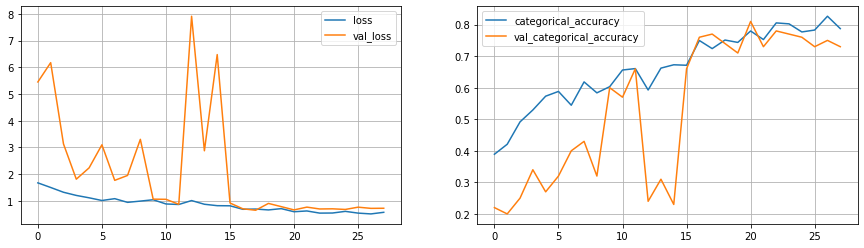

In [ ]:
# plot(history_model1)

Model 2

Adding dropout layers - Batch Size = 8 and No. of Epochs = 30

In [ ]:
# class ModelConv3D1(ModelBuilder):
    
#     def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

#         model = Sequential()
#         model.add(Conv3D(16, filtersize, padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(32, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(64, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(128, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Flatten())
#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))

#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))


#         model.add(Dense(self.num_classes,activation='softmax'))

#         optimiser = optimizers.Adam()
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# conv_3d2=ModelConv3D1()
# conv_3d2.initialize_path(project_folder)
# conv_3d2.initialize_image_properties(image_height=160,image_width=160)
# conv_3d2.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
# conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
# conv_3d2_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 160, 160, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 16, 160, 160, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 16, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 80, 80, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 80, 80, 32)     13856     
                                                                 
 activation_25 (Activation)  (None, 8, 80, 80, 32)    

In [ ]:
# print("Total Params:", conv_3d2_model.count_params())
# history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 2.1043 - categorical_accuracy: 0.3477
Epoch 1: val_loss improved from inf to 5.76226, saving model to model_init_2023-02-1812_28_07.819966/model-00001-2.10431-0.34766-5.76226-0.16000.h5
83/83 [==============================] - 160s 2s/step - loss: 2.1043 - categorical_accuracy: 0.3477 - val_loss: 5.7623 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.8366 - categorical_accuracy: 0.3612
Epoch 2: val_loss did not improve from 5.76226
83/83 [==============================] - 161s 2s/step - loss: 1.8366 - categorical_accuracy: 0.3612 - val_loss: 6.2599 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.6610 - categorical_accuracy: 0.3997
Epoch 3: val_loss improved from 5.76226 to 2.33315, saving model to model_init_2023-02-1812_28_07.819966/model-00003-1.66098-0.3997

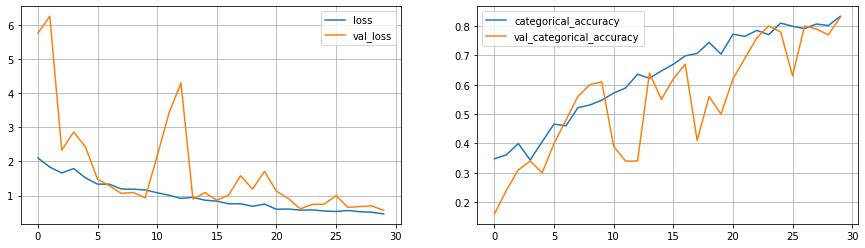

In [ ]:
# plot(history_model2)

Model 3

Reduce filter size to (2,2,2) and image res to 120 x 120, - Batch Size = 30 and No. of Epochs = 30

In [ ]:
# class ModelConv3D3(ModelBuilder):
    
#     def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

#         model = Sequential()
#         model.add(Conv3D(16, filtersize, padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(32, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(64, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(128, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Flatten())
#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))

#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))


#         model.add(Dense(self.num_classes,activation='softmax'))
        
#         optimiser = optimizers.Adam(lr=0.0002)
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# conv_3d3=ModelConv3D3()
# conv_3d3.initialize_path(project_folder)
# conv_3d3.initialize_image_properties(image_height=120,image_width=120)
# conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
# conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
# conv_3d3_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_28 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_29 (Activation)  (None, 8, 60, 60, 32)    

In [ ]:
# print("Total Params:", conv_3d3_model.count_params())
# history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 2.0521 - categorical_accuracy: 0.3318
Epoch 1: val_loss improved from inf to 3.04305, saving model to model_init_2023-02-1813_48_09.235050/model-00001-2.05208-0.33183-3.04305-0.16000.h5
83/83 [==============================] - 143s 2s/step - loss: 2.0521 - categorical_accuracy: 0.3318 - val_loss: 3.0431 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.5400 - categorical_accuracy: 0.4646
Epoch 2: val_loss did not improve from 3.04305
83/83 [==============================] - 141s 2s/step - loss: 1.5400 - categorical_accuracy: 0.4646 - val_loss: 4.4213 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.3656 - categorical_accuracy: 0.5271
Epoch 3: val_loss did not improve from 3.04305
83/83 [==============================] - 139s 2s/step - loss: 1.3656 - categ

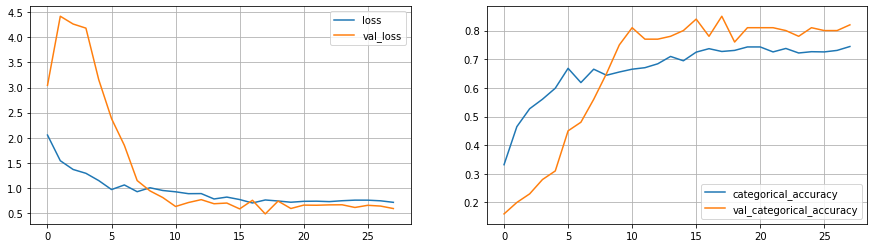

In [ ]:
# plot(history_model3)

Model 4

Adding more layers - Batch Size = 8 and No. of Epochs = 30

In [ ]:
# class ModelConv3D4(ModelBuilder):
    
#     def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

#         model = Sequential()
#         model.add(Conv3D(16, filtersize, padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(Conv3D(16, filtersize, padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(32, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(Conv3D(32, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(64, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(Conv3D(64, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(128, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(Conv3D(128, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

#         model.add(Flatten())
#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))

#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))


#         model.add(Dense(self.num_classes,activation='softmax'))

#         optimiser = optimizers.Adam()
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# conv_3d4=ModelConv3D4()
# conv_3d4.initialize_path(project_folder)
# conv_3d4.initialize_image_properties(image_height=120,image_width=120)
# conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
# conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
# conv_3d4_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_48 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_33 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_33 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_49 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [ ]:
# print("Total Params:", conv_3d4_model.count_params())
# history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 2.2176 - categorical_accuracy: 0.3198
Epoch 1: val_loss improved from inf to 3.61439, saving model to model_init_2023-02-1814_53_46.617185/model-00001-2.21756-0.31976-3.61439-0.16000.h5
83/83 [==============================] - 143s 2s/step - loss: 2.2176 - categorical_accuracy: 0.3198 - val_loss: 3.6144 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.9349 - categorical_accuracy: 0.3537
Epoch 2: val_loss did not improve from 3.61439
83/83 [==============================] - 141s 2s/step - loss: 1.9349 - categorical_accuracy: 0.3537 - val_loss: 4.8932 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.7638 - categorical_accuracy: 0.3710
Epoch 3: val_loss did not improve from 3.61439
83/83 [==============================] - 139s 2s/step - loss: 1.7638 - categorical_a

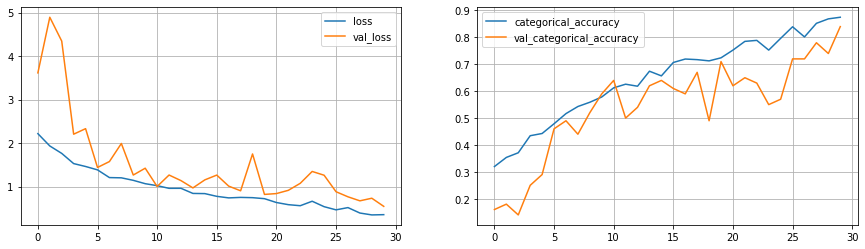

In [ ]:
# plot(history_model4)

Model 5

Adding dropout at convolution layers

In [ ]:
# class ModelConv3D5(ModelBuilder):
    
#     def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

#         model = Sequential()
#         model.add(Conv3D(16, filtersize, padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(Conv3D(16, filtersize, padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#         model.add(Dropout(dropout))

#         model.add(Conv3D(32, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(Conv3D(32, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#         model.add(Dropout(dropout))

#         model.add(Conv3D(64, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(Conv3D(64, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#         model.add(Dropout(dropout))

#         model.add(Conv3D(128, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(Conv3D(128, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#         model.add(Dropout(dropout))
        
#         model.add(Flatten())
#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))

#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))


#         model.add(Dense(self.num_classes,activation='softmax'))

#         optimiser = optimizers.Adam()
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# conv_3d5=ModelConv3D5()
# conv_3d5.initialize_path(project_folder)
# conv_3d5.initialize_image_properties(image_height=120,image_width=120)
# conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
# conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
# conv_3d5_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_58 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_41 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_41 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_59 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [ ]:
# print("Total Params:", conv_3d5_model.count_params())
# history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.7995 - categorical_accuracy: 0.3650
Epoch 1: val_loss improved from inf to 4.08291, saving model to model_init_2023-02-1816_04_15.140277/model-00001-1.79948-0.36501-4.08291-0.16000.h5
83/83 [==============================] - 142s 2s/step - loss: 1.7995 - categorical_accuracy: 0.3650 - val_loss: 4.0829 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.5027 - categorical_accuracy: 0.4005
Epoch 2: val_loss improved from 4.08291 to 2.71313, saving model to model_init_2023-02-1816_04_15.140277/model-00002-1.50274-0.40045-2.71313-0.24000.h5
83/83 [==============================] - 143s 2s/step - loss: 1.5027 - categorical_accuracy: 0.4005 - val_loss: 2.7131 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.2911 - categorical_accuracy: 0.5068
Epoch 3: val_loss improved

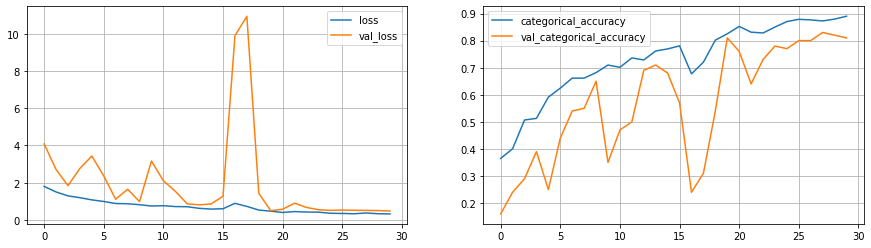

In [ ]:
# plot(history_model5)

Model 6

Reducing the number of parameters

In [ ]:
# class ModelConv3D6(ModelBuilder):
    
#     def define_model(self,dense_neurons=64,dropout=0.25):

#         model = Sequential()
#         model.add(Conv3D(16, (3, 3, 3), padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(32, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(64, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(128, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
#         model.add(Flatten())
#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))

#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))

#         model.add(Dense(self.num_classes,activation='softmax'))

#         optimiser = optimizers.Adam(lr=0.0002)
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# conv_3d6=ModelConv3D6()
# conv_3d6.initialize_path(project_folder)
# conv_3d6.initialize_image_properties(image_height=100,image_width=100)
# conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
# conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
# conv_3d6_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_68 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_49 (Activation)  (None, 8, 50, 50, 32)   

In [ ]:
# print("Total Params:", conv_3d6_model.count_params())
# history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.7060 - categorical_accuracy: 0.3665
Epoch 1: val_loss improved from inf to 2.72302, saving model to model_init_2023-02-1817_14_40.335690/model-00001-1.70601-0.36652-2.72302-0.16000.h5
83/83 [==============================] - 134s 2s/step - loss: 1.7060 - categorical_accuracy: 0.3665 - val_loss: 2.7230 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.2907 - categorical_accuracy: 0.4977
Epoch 2: val_loss did not improve from 2.72302
83/83 [==============================] - 134s 2s/step - loss: 1.2907 - categorical_accuracy: 0.4977 - val_loss: 4.0283 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.1522 - categorical_accuracy: 0.5611
Epoch 3: val_loss did not improve from 2.72302
83/83 [==============================] - 135s 2s/step - loss: 1.1522 - catego

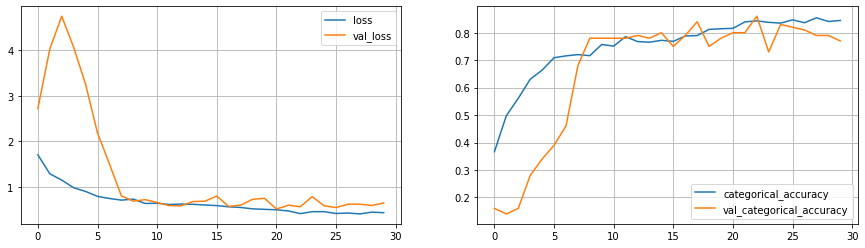

In [ ]:
# plot(history_model6)

Model 7 - Reducing the number of parameters again

In [ ]:
# class ModelConv3D7(ModelBuilder):
    
#     def define_model(self,dense_neurons=64,dropout=0.25):

#         model = Sequential()
#         model.add(Conv3D(16, (3, 3, 3), padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(32, (3, 3, 3), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(64, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(128, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
#         model.add(Flatten())
#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))

#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(dropout))

#         model.add(Dense(self.num_classes,activation='softmax'))

#         optimiser = optimizers.Adam(lr=0.0002)
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# conv_3d7=ModelConv3D7()
# conv_3d7.initialize_path(project_folder)
# conv_3d7.initialize_image_properties(image_height=120,image_width=120)
# conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
# conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
# conv_3d7_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_74 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_53 (Activation)  (None, 8, 60, 60, 32)   

In [ ]:
# print("Total Params:", conv_3d7_model.count_params())
# history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.6543 - categorical_accuracy: 0.3974
Epoch 1: val_loss improved from inf to 2.78051, saving model to model_init_2023-02-1818_22_04.978164/model-00001-1.65435-0.39744-2.78051-0.18000.h5
83/83 [==============================] - 142s 2s/step - loss: 1.6543 - categorical_accuracy: 0.3974 - val_loss: 2.7805 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.3391 - categorical_accuracy: 0.4646
Epoch 2: val_loss did not improve from 2.78051
83/83 [==============================] - 142s 2s/step - loss: 1.3391 - categorical_accuracy: 0.4646 - val_loss: 3.6569 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.1795 - categorical_accuracy: 0.5543
Epoch 3: val_loss did not improve from 2.78051
83/83 [==============================] - 140s 2s/step - loss: 1.1795 - catego

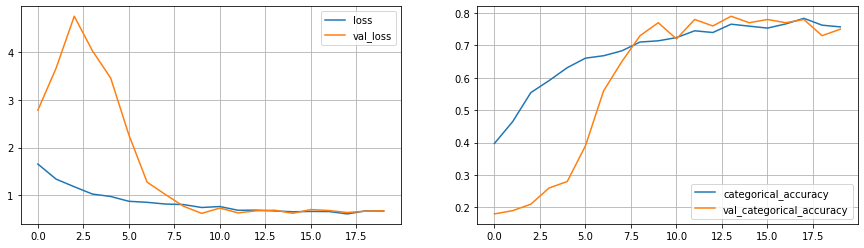

In [ ]:
# plot(history_model7)

RNN 

In [ ]:
# class ModelBuilder(metaclass= abc.ABCMeta):
#     # initialisng the path where project data resides
#     def initialize_path(self,project_folder):
#         self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
#         self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
#         self.train_path = project_folder + '/' + 'train'
#         self.val_path =  project_folder + '/' + 'val'
#         self.num_train_sequences = len(self.train_doc)
#         self.num_val_sequences = len(self.val_doc)
#     # initialising the image properties    
#     def initialize_image_properties(self,image_height=100,image_width=100):
#         self.image_height=image_height
#         self.image_width=image_width
#         self.channels=3
#         self.num_classes=5
#         self.total_frames=30
#     # initialising the batch size, frames to sample and the no. of epochs
#     def initialize_hyperparams(self,frames_to_sample=16,batch_size=8,num_epochs=20):
#         self.frames_to_sample=frames_to_sample
#         self.batch_size=batch_size
#         self.num_epochs=num_epochs
        
#     # MOST IMPORTANT PART HERE - The generator function        
#     def generator(self,source_path, folder_list, augment=False):
#         img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
#         batch_size=self.batch_size
#         while True:
#             t = np.random.permutation(folder_list)
#             num_batches = len(t)//batch_size
        
#             for batch in range(num_batches): 
#                 batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
#                 yield batch_data, batch_labels 

#             remaining_seq=len(t)%batch_size
        
#             if (remaining_seq != 0):
#                 batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
#                 yield batch_data, batch_labels 
    
    
#     def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
#         seq_len = remaining_seq if remaining_seq else batch_size
    
#         batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
#         batch_labels = np.zeros((seq_len,self.num_classes)) 
    
#         if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
#         for folder in range(seq_len): 
#             imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#             for idx,item in enumerate(img_idx):
#                 #performing image reading and resizing
#                 image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
#                 image_resized=resize(image,(self.image_height,self.image_width,3))
            
#                 #normalizing the images
#                 batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
#                 batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
#                 batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
#                 if (augment):
#                     shifted = cv2.warpAffine(image, 
#                                              np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
#                                             (image.shape[1], image.shape[0]))
                    
#                     gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

#                     x0, y0 = np.argwhere(gray > 0).min(axis=0)
#                     x1, y1 = np.argwhere(gray > 0).max(axis=0) 
#                     # cropping the images to have the targeted gestures and remove the noise from the images.
#                     cropped=shifted[x0:x1,y0:y1,:]
                    
#                     image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
#                     #shifted = cv2.warpAffine(image_resized, 
#                     #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
#                     #                        (image_resized.shape[1], image_resized.shape[0]))
            
#                     batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
#                     batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
#                     batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
#             batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
#         if (augment):
#             batch_data=np.concatenate([batch_data,batch_data_aug])
#             batch_labels=np.concatenate([batch_labels,batch_labels])

        
#         return(batch_data,batch_labels)
    
    
#     def train_model(self, model, augment_data=False):
#         train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
#         val_generator = self.generator(self.val_path, self.val_doc)

#         model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
#         if not os.path.exists(model_name):
#             os.mkdir(model_name)
        
#         filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#         checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#         LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
#         earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
#         callbacks_list = [checkpoint, LR, earlystop]

#         if (self.num_train_sequences%self.batch_size) == 0:
#             steps_per_epoch = int(self.num_train_sequences/self.batch_size)
#         else:
#             steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

#         if (self.num_val_sequences%self.batch_size) == 0:
#             validation_steps = int(self.num_val_sequences/self.batch_size)
#         else:
#             validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
#         history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
#                             callbacks=callbacks_list, validation_data=val_generator, 
#                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#         return history

        
#     @abc.abstractmethod
#     def define_model(self):
#         pass

In [ ]:
# class ModelConv3D1(ModelBuilder):
    
#     def define_model(self):

#         model = Sequential()
#         model.add(Conv3D(16, (3, 3, 3), padding='same',
#                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(32, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(64, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(128, (2, 2, 2), padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
#         model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Flatten())
#         model.add(Dense(128,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.5))

#         model.add(Dense(64,activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.25))


#         model.add(Dense(self.num_classes,activation='softmax'))

#         optimiser = optimizers.Adam()
#         #optimiser = 'sgd'
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# conv_3d1=ModelConv3D1()
# conv_3d1.initialize_path(project_folder)
# conv_3d1.initialize_image_properties(image_height=160,image_width=160)
# conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=1)
# conv_3d1_model=conv_3d1.define_model()
# conv_3d1_model.summary()

In [ ]:
# test_generator=ModelConv3D1()
# test_generator.initialize_path(project_folder)
# test_generator.initialize_image_properties(image_height=160,image_width=160)
# test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=3,num_epochs=1)

# g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
# batch_data, batch_labels=next(g)
# fig, axes = plt.subplots(nrows=1, ncols=2)
# axes[0].imshow(batch_data[0,15,:,:,:])   
# axes[1].imshow(batch_data[3,15,:,:,:])   
# plt.show()

In [ ]:
# class RNNCNN1(ModelBuilder):
    
#     def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

#         model = Sequential()

#         model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
#                                   input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(TimeDistributed(BatchNormalization()))
#         model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
#         model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
#         model.add(TimeDistributed(BatchNormalization()))
#         model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
#         model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
#         model.add(TimeDistributed(BatchNormalization()))
#         model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
#         model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
#         model.add(TimeDistributed(BatchNormalization()))
#         model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
#         model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
#         model.add(TimeDistributed(BatchNormalization()))
#         model.add(TimeDistributed(MaxPooling2D((2, 2))))

#         model.add(TimeDistributed(Flatten()))


#         model.add(LSTM(lstm_cells))
#         model.add(Dropout(dropout))
        
#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(Dropout(dropout))
        
#         model.add(Dense(self.num_classes, activation='softmax'))
#         optimiser = optimizers.Adam()
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# rnn_cnn1=RNNCNN1()
# rnn_cnn1.initialize_path(project_folder)
# rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
# rnn_cnn1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
# rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
# rnn_cnn1_model.summary()

In [ ]:
# print("Total Params:", rnn_cnn1_model.count_params())
# history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=False)

In [ ]:
# print("Total Params:", rnn_cnn1_model.count_params())
# history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

In [ ]:
# class RNNCNN2(ModelBuilderMoreAugmentation):
    
#     def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

#         model = Sequential()

#         model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
#                                   input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#         model.add(TimeDistributed(BatchNormalization()))
#         model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
#         model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
#         model.add(TimeDistributed(BatchNormalization()))
#         model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
#         model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
#         model.add(TimeDistributed(BatchNormalization()))
#         model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
#         model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
#         model.add(TimeDistributed(BatchNormalization()))
#         model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

#         model.add(TimeDistributed(Flatten()))


#         model.add(GRU(lstm_cells))
#         model.add(Dropout(dropout))
        
#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(Dropout(dropout))
        
#         model.add(Dense(self.num_classes, activation='softmax'))
#         optimiser = optimizers.Adam(lr=0.0002)
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# rnn_cnn2=RNNCNN2()
# rnn_cnn2.initialize_path(project_folder)
# rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
# rnn_cnn2.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
# rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
# rnn_cnn2_model.summary()

In [ ]:
# print("Total Params:", rnn_cnn2_model.count_params())
# history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

In [ ]:
# plot(history_model15)

In [ ]:
# from keras.applications import mobilenet

In [ ]:
# mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

# class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
#     def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
#         model = Sequential()
#         model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
#         for layer in model.layers:
#             layer.trainable = False
        
        
#         model.add(TimeDistributed(BatchNormalization()))
#         model.add(TimeDistributed(MaxPooling2D((2, 2))))
#         model.add(TimeDistributed(Flatten()))

#         model.add(LSTM(lstm_cells))
#         model.add(Dropout(dropout))
        
#         model.add(Dense(dense_neurons,activation='relu'))
#         model.add(Dropout(dropout))
        
#         model.add(Dense(self.num_classes, activation='softmax'))
        
        
#         optimiser = optimizers.Adam()
#         model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#         return model

In [ ]:
# rnn_cnn_tl=RNNCNN_TL()
# rnn_cnn_tl.initialize_path(project_folder)
# rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
# rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
# rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
# rnn_cnn_tl_model.summary()

In [ ]:
# print("Total Params:", rnn_cnn_tl_model.count_params())
# history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

In [ ]:
# plot(history_model16)

In [13]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

In [15]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.0329 - categorical_accuracy: 0.5973
Epoch 1: val_loss improved from inf to 0.49638, saving model to model_init_2023-02-2104_40_37.083249/model-00001-1.03285-0.59729-0.49638-0.85000.h5
83/83 [==============================] - 282s 3s/step - loss: 1.0329 - categorical_accuracy: 0.5973 - val_loss: 0.4964 - val_categorical_accuracy: 0.8500 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.5183 - categorical_accuracy: 0.7941
Epoch 2: val_loss did not improve from 0.49638
83/83 [==============================] - 254s 3s/step - loss: 0.5183 - categorical_accuracy: 0.7941 - val_loss: 0.8381 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.4110 - categorical_accuracy: 0.8522
Epoch 3: val_loss improved from 0.49638 to 0.28369, saving model to model_init_2023-02-2104_40_37.083249/model-00003-0.41101-0.8521

In [ ]:
plot(history_model17)